# Overview

This program can be used to compute the BPS spectrum of the $\mathcal{N}=2^*$ theory. The starting point is the spectrum at a wall of marginal stability, where one of the basis charges $\gamma_3$ aligns with the flavor charge $\gamma_f$ as well as the vector $\gamma_1+\gamma_2$. The spectrum away from the wall can then be obtained by an algorithm of perturbing the spectrum slightly and then applying the wall crossing formula on the spectrum generator $\mathcal{S}$, which is an ordered product of symplectomorphisms $\mathcal{K}_{\gamma}$ associated to BPS states $\gamma$.

We start with two sections defining all necessary functions. If you just want to use the program, please skip the "Parameters and Options" or "Resulting Spectrum and Diagnostics". Note that the default parameter setup computes the spectrum for the `subcut=4`case of the paper.

# Setup

In this section we define all functions used in the program except for the main function which is the actual algorithm to compute the spectrum and which is defined in the next section.

In [1]:
import cmath #used to compute the phase of the central charges Z(gamma)
import numpy as np #for some of the list operations we use it is easier to use numpy arrays
import warnings #we have to suppress some warnings and this package does that
import matplotlib.pyplot as plt #plotting
import json #storing of results

warnings.simplefilter(action='ignore', category=FutureWarning)

#We use the phase function a lot, so it is handy to give it a nicer name
def arg(x):
    return cmath.phase(x)

The objects we consider are *charges* $\gamma$, which have a central charge $Z(\gamma)$, an EM charge, a name, a level, and a weight under the perturbation of the spectrum away from the wall by $Z(\gamma_1)\mapsto Z(\gamma_1)+\epsilon Z(\gamma_2)$.

To keep track of the EM charges, we just use a (non-unique) basis decomposition into charges $\gamma_i$ $i=1,2,3$, where $\langle\gamma_i,\gamma_{i+1}\rangle=2$ (with i taken mod 3).

The level is used later to truncate the spectrum away from the wall.

In [2]:
class Charge:
    def __init__(self, Z, EM, name, lvl, pweight=0):
        self.Z = Z #central charge
        self.EM = EM #EM charge
        self.name = name 
        self.lvl = lvl #level
        self.pweight = pweight #weight for the perturbation
    
    #show(charge) gives all the attributes of a charge
    def show(self):
        return(self.Z, self.EM, self.name, self.lvl, self.pweight)
    
    #We define the addition of two charges and overload the "+" operator for this
    def __add__(self, other):
        return(Charge(self.Z + other.Z,
                      [self.EM[i] + other.EM[i] for i in range(3)],
                      "",
                      max(self.lvl, other.lvl) + 1,
                      self.pweight + other.pweight
                     )) #note that we just forget the name of the charge, and give it by hand whenever needed
    
    #Similarly we can multiply a charge with an integer from either side
    def __mul__(self, integer):
        out = Charge(0, [0,0,0], "", 0, 0)
        level = self.lvl #The way we use it, multiplication does not change the level
        for n in range(integer):
            out = out + self
            out.lvl = level
        return out
    def __rmul__(self, integer):
        return self * integer
    
    #We also need the electromagnetic pairing
    def pairing(self, other):
        EM11, EM12, EM13 = int(self.EM[0]), int(self.EM[1]), int(self.EM[2])
        EM21, EM22, EM23 = int(other.EM[0]), int(other.EM[1]), int(other.EM[2])
        prng = 2*(EM11*(EM22 - EM23) + EM12*(EM23 - EM21) + EM13*(EM21 - EM22))
        return(prng)

We define a simple function to create a family of charges of the form $(n+1)\gamma_1 + n \gamma_2$ 

In [3]:
def halffamily(charge1, charge2, cutoff, namesgn="", namecut=75, revname=False):
    charges = [charge1]
    for n in range(1,cutoff+1):
        charge = (n+1)*charge1 + n*charge2
        #To keep naming conventions homogeneous, we allow for two different ways to paste names together
        if revname==False:
            charge.name = charge1.name + "&" + charge2.name + ";" + namesgn + str(n)
        if revname==True:
            charge.name = charge2.name + "&" + charge1.name + ";" + namesgn + str(n)
        if len(charge.name)>namecut:
            charge.name = ".." + charge.name[-(namecut-2)::]
        charges.append(charge)
    return charges

We then use this function to also build another one, that produces the states for the $\langle\gamma_1,\gamma_2,\rangle=2$ KS wall crossing formular. These are the hypers $(n+1)\gamma_1 + n \gamma_2$, $n\gamma_1 + (n+1) \gamma_2$ as well as the vector $\gamma_1+\gamma_2$.

In [4]:
def fullfamily(charge1, charge2, cutoff, namecut=75):
    chargesr = halffamily(charge1, charge2, cutoff, namesgn="+", namecut=namecut)
    chargesinf = charge1 + charge2
    chargesinf.name = charge1.name + "&" + charge2.name + ";" + "inf"
    if len(chargesinf.name)>namecut:
        chargesinf.name = ".." + chargesinf.name[-(namecut-2)::]
    chargesinf = [chargesinf]
    chargesl = halffamily(charge2, charge1, cutoff, namesgn="-", namecut=namecut, revname=True)[::-1]
    charges = chargesr + chargesinf + chargesl
    return charges

Sorting of charges by the phase of their central charge is crucial for the computation. We also output a `sortkey` which is the `np.argsort()` of the input charges. This is very useful to understand the reordering of charges and find the permutations that need done.

We also often use the reverse sortkey, which is `[sortkey[index[i]] for i in range(len(sortkey))]`. `sortkey[i]` specifies which state needs to be at the $i$th position, while its `reversekey[i]` specifies where the $i$th state needs to be moved to sort the list. Note that `sortkey[reversekey[i]] = [1,2,3,4...]`, so these two lists are inverse in that sense.

In [5]:
def chargesort(charges):
    sortkey = np.argsort([arg(charge.Z) for charge in charges]).tolist()
    scharges = [charges[i] for i in sortkey]
    return scharges, sortkey

We have two functions to extract simple information from the `sortkey` which is part of the output of chargesort

In [6]:
def keychanges(key):
    return(int(sum([abs(key[i]-i) for i in range(len(key))])/2))

In [7]:
def keydistances(key):
    return(max([abs(key[i]-i) for i in range(len(key))]))

We usually enforce no two charges to coincide in their phase and this function checks that

In [8]:
def equalcharge(charges):
    outnames = []
    outargs = []
    for i in range(len(charges)-1):
        if arg(charges[i].Z)==arg(charges[i+1].Z):
            outnames.append([charges[i].name,charges[i+1].name])
            outargs.append(arg(charges[i].Z))
    return(outnames, outargs)

We keep track of some noticable behavior of charges and for this want to merge lists without keeping duplicates

In [9]:
def listmerge(list1, list2):
    outlist = [] + list1
    for entry in list2:
        if entry not in outlist:
            outlist.append(entry)
    return outlist

Finally one of our main functions for the program is used to compute the resulting states from the wall crossing formula as $\mathcal{K}_{\gamma}$ is permuted past other states. This function allows to permute one charge `charge1` past one or more charges `charges2` (input can be list of charges or single charge). Each time the pairing is computed and then the appropriate boundstates are constructed. 

Negative pairings are unexpected and are kept track off via `neglist`. Pairings larger than $2$ really shouldn't occur and will terminate the algorithm. Permutations of factors $\mathcal{K}^{-2}_{\gamma_{\text{vector}}}$ are also somewhat unexpected and are kept track of in `inflist`.

In [10]:
def gammapermute(charge1, charges2, cutoff, namecut=150, lvlcut=9999, negdetect=False,infdetect=False):
    neglist=[]
    inflist=[]
    if type(charges2)!=list:
        charges2 = [charges2]
    charges = [charge1]
    for n in range(len(charges2)):
        pairing = charge1.pairing(charges2[n])
        if infdetect:
            if 'inf' in charge1.name or 'inf' in charges2[n].name:
                inflist.append([charge1.name, charges2[n].name, pairing])
        if pairing>2:
            return ("Pairing "+str(pairing)+" encountered for "+charge1.name+" & "+charges2[n].name), neglist, inflist
        if negdetect:
            if pairing<0:
                neglist.append([charge1.name, charges2[n].name, pairing])
        if max(charge1.lvl, charges2[n].lvl)<lvlcut and pairing==2:
            bndcharges = fullfamily(charge1, charges2[n], cutoff, namecut)[1:-1]
            charges = charges + bndcharges
        if max(charge1.lvl, charges2[n].lvl)<lvlcut and pairing==1:
            bndcharge = charge1 + charges2[n]
            bndcharge.name = charge1.name + "&" + charges2[n].name
            charges = charges + [bndcharge]
        charges = charges + [charges2[n]]
    return charges, neglist, inflist

We perturb the spectrum by adding $\epsilon$ $Z_p$ taken times the perturbation weight. $\gamma_1$ has `pweight` $1$, $\gamma_2$ has $0$ and $\gamma_3$ has $-1$. Adding two charges adds their `pweight`.

In [11]:
def perturbcharges(charges, pertcharge, stepsize):
    return([Charge(
        charge.Z + stepsize * charge.pweight * pertcharge.Z,
        charge.EM,
        charge.name,
        charge.lvl,
        charge.pweight
    ) for charge in charges])

We use two kind of criteria to evaluate if a permutation is safe to perform. `permnice` enforces some criteria which ensure that permutations can be broken down into simple permutations of neighboring charges and prevent some pathological behavior that could occur. `permsize` is just concerned with the size of permutations.

In [12]:
def permnice(spectrum, skey):
    #Simple permutations are always allowed and shortcut the function to reduce computations
    if keychanges(skey)==1:
        return True
    #we will use this list a few times to keep track of permutations that occur
    rkey = [skey.index(i) for i in range(len(skey))]
    rkeychanges = [rkey[i]-i for i in range(len(rkey))]+ [0] #adding [0] at the end fixes some bugs
    i = 0
    #print(rkeychanges) #if you run into issues, uncomment this and the next print command to see details
    while i<len(rkey):
        if rkeychanges[i]!=0:
            #We find a block of permutations that add up to 0
            j = 1
            while sum(rkeychanges[i:i+j+1])!=0:
                j = j + 1
            rkeyblock = rkeychanges[i:i+j+1]
            chargeblock = spectrum[i:i+j+1]
            #print(rkeyblock) #handy to see details, if issues occur
            badblock = False
            #Blocks with permutations up to 2 steps should be fine unless they contain a 0
            if 0 in rkeyblock:
                badblock = True
            permlength = max(max(rkeyblock),-min(rkeyblock))
            #Blocks with larger permutations need investigated unless they are of a simple form
            if permlength>2:
                badblock = True
                if sum([entry==-1 for entry in rkeyblock])==permlength:
                    badblock = False
                elif sum([entry==1 for entry in rkeyblock])==permlength:
                    badblock = False
            #Blocks which might cause issues are flagged and only allowed if only one permutation is non-trivial
            if badblock:  
                pairings = []
                for k in range(j+1):
                    for l in range(k,j+1):
                        pairings.append(chargeblock[k].pairing(chargeblock[l]))
                if sum(prng!=0 for prng in pairings)>1:
                    return False
            i = i + j
        i = i + 1
    return True

In [13]:
def permsize(skey, permlength, permnumber):
    if keychanges(skey)==1:
        return True   
    if permnumber!=0 and keychanges(skey)>permnumber:
        return False
    #we will use this list a few times to keep track of permutations that occur
    skeychanges = [skey[i]-i for i in range(len(skey))] + [0] #adding [0] at the end fixes some bugs
    n = max(max(skeychanges),-min(skeychanges))
    if permlength!=0 and n>permlength:
        return False
    return True

# Full Algorithm

This defines the full algorithm we are going to run. We always do a small perturbation of the spectrum, check that the permutations of states it leads to is "nice" enough, and then perform the permutation, pasting in any new states that result from the KSWCF. If the permutation is not nice enough, we instead try a perturbation with adjusted stepsize. We also keep track of some interesting behavior which is noteworthy in SU(2) theories, as well as some diagnostics which can be handy whenever the program fails to terminate for one reason or another.

There are a lot of options going into this function, but we package all of those into a list in a cell in the Parameters section.

In [14]:
def computespectrum(spectrum0, pertcharge, options):
    [epstarget, step, permlength, permnumber, negexclude, infexclude, equalexclude, lpermdetect, stepthres, 
     stepgrowth, stepdecay, minstep, loopbreak, kcut, subcut, lvlcut] = options
    #we initialise some basic things like the loopcount
    loopcount, stepcount, totaleps = 0, 0, 0
    #the diagnostics are part of the output and help to identify issues if the program gets stuck
    diagnostics = [loopcount, totaleps,step]
    #we also record some unexpected behavior which is worth noting for SU2 theories
    negdetlist, infdetlist, lpermlist = [], [], []
    #we initialise the spectrum as the one that is given as input  and then sort it and keep the sortkey
    spectrum = spectrum0
    sspectrum, skey = chargesort(spectrum)
    runloop = True
    #we now run through the main loop
    while runloop:
        #replace the old spectrum with a perturbed one and sort again
        spectrum = perturbcharges(spectrum, pertcharge, step)
        totaleps = totaleps + step
        diagnostics[1], diagnostics[2] = totaleps, step
        sspectrum, skey = chargesort(spectrum)
        #check permutation criteria hold
        fullcriterium = permsize(skey, permlength, permnumber) and permnice(spectrum, skey)
        if equalexclude:
            fullcriterium = fullcriterium and equalcharge(spectrum)[0]==[]
        #if permutation criteria are satisfied, reorder charges and add boundstates from KSWCF
        if fullcriterium:
            while keychanges(skey)>0:
                stepcount = 0
                #We will keep track of larger permutations
                if lpermdetect and keychanges(skey)>1:
                    lpermlist.append(spectrum)
                #We do the necessary permutations step by step
                rkey = [skey.index(i) for i in range(len(skey))]
                rkeychanges = [rkey[i] - i for i in range(len(rkey))]
                #We find the first state to be permuted forwards
                j = [n<0 for n in rkeychanges].index(True)
                #We permute this state one step to the left and add the resulting boundstates
                newneg = []
                permstates, newneg, newinf = gammapermute(spectrum[j],spectrum[j-1],
                                                  subcut, lvlcut=lvlcut, negdetect=True, infdetect=True)
                if type(permstates)==str: #gammapermute will not allow pairings >2 and we halt in that case
                    print(permstates)
                    runloop = False
                    break
                #We also keep track of negative pairings as we encounter them, but we remove duplicates
                negdetlist = listmerge(negdetlist, newneg)
                infdetlist = listmerge(infdetlist, newinf)
                #We might even want to halt completely, if we encounter one
                if negexclude:
                    if len(negdetlist)>0:
                        print("Negative pairing encountered")
                        print(negdetlist)
                        runloop = False
                        break
                if infexclude:
                    if len(infdetlist)>0:
                        print("Permutation involving vector encountered")
                        print(infdetlist)
                        runloop = False
                        break
                if runloop:
                    #We then patch these states in
                    spectrum = spectrum[0:j-1] + permstates + spectrum[j+1::]
                    sspectrum, skey = chargesort(spectrum)
                #finally we check the permutation criteria again at the end
                if not permnice(spectrum, skey):
                    print("Permnice broken at end of loop")
                    runloop = False
                    break
                if not permsize(skey, permlength, permnumber):
                    print("permsize broken at end of loop")
                    #runloop = False
                    #break
            #we keep track of successive perturbations and reset this count whenever the order of states changed
            stepcount = stepcount + 1
        #If the perturbation didn't fulfill the criteria, we adjust the stepsize; usually we lower it
        else:
            increasestep = False
            if equalexclude and equalcharge(spectrum)[0]:
                increasestep = True #if the permutation fails because of equalcharge, we need to try push past it
            spectrum = perturbcharges(spectrum, pertcharge, -step)
            totaleps = totaleps - step
            diagnostics[1] = totaleps
            sspectrum, skey = chargesort(spectrum)
            #unless we encountered charges aligning, we decrease the stepsize
            if not increasestep:
                step = stepdecay * step
            #we set a minimal stepsize and halt if we go any lower. This is to halt loops of shrinking stepsize
            if step < minstep:
                print("Stepsize is smaller than specified minimum.")
                break
            if increasestep:
                step = stepgrowth * step
            diagnostics[2] = step
            stepcount = 0
        #if we encounter a few steps without any permutations, we increase the stepsize
        if stepcount == stepthres:
            step = stepgrowth * step
            diagnostics[2] = step
            stepcount = 0
        if totaleps == epstarget:
            print("Epstarget reached")
            break
        if epstarget - totaleps < step:
            step = epstarget - totaleps
            diagnostics[2] = step
        loopcount = loopcount + 1
        diagnostics[0] = loopcount
        # we print progress in form of counts of the main loop
        if loopcount%500==0:
            print(str(loopcount) + " iteration(s) done.")
        if loopcount == loopbreak:
            print("Limit of loop iterations reached in the perturbation.")
            break
    return spectrum, sspectrum, skey, negdetlist, infdetlist, lpermlist, diagnostics

## Parameters and Options

We input the central charges $Z_1$, $Z_2$ and the mass $m=Z_1+Z_2+Z_3$ as initial parameters. We also have an option to include or exclude $\gamma_1+\gamma_2+\gamma_f$ in the calculation. It is generally advisable to exclude it, as its inclusion leads to complicated behavior. In that case it will be added to the spectrum at the end.

There are also some options for cutoffs of the infinite aspects of the spectrum, as well as perturbation $\epsilon$ to be reached at the end of it.

The main parameters that really should be varied are `m` and `epstarget` which are of physical relevance, specifying the mass and the size $\delta$ of the perturbation away from the wall. Furthermore `kcut`, `subcut`, and `lvlcut` need to be adjusted carefully to compute as much of the spectrum as possible, while still having the algorithm terminate.

In [15]:
Z2 = complex(-1,1)
Z1 = complex(1,1)
m = complex(0,3) #The mass should be chosen imaginary
includevf = 0 #put to 1 to include gammavf in the calculation
kcut =  7 #this is the initial cut for the states that exist on the wall of marginal stability
subcut = 4 #this is the cut for any further states
lvlcut = 8
epstarget = 0.15*0.98 #the final perturbation that we want to reach

We then construct the initial charges from this and also construct the first set of boundstates. We show the list of charges and the sorted list as it will be after `epstarget` is reached. This can be used to find the correct `kcut` to have charges up to `gammavf` included, but not much more.

In [16]:
Z3 = m - Z1 - Z2
gamma1 = Charge(Z1, [1,0,0], "1", 0, 1)
gamma2 = Charge(Z2, [0,1,0], "2", 0, 0)
gamma3 = Charge(Z3, [0,0,1], "3", 0, -1)
gammavf = 2*gamma1+2*gamma2+gamma3 #The state gamma_1+gamma_2+gamma_f is of particular relevance for us
gammavf.lvl, gammavf.name = 0, "1+2+f"
gammav = gamma1+gamma2
gammav.lvl, gammav.name = 0, "v"
kgammas = halffamily(gamma1, gamma2, kcut)
spectrum0 = kgammas + [gamma3] + includevf*[gammavf] + [gammav]
print([charge.name for charge in spectrum0])
testspectrum = chargesort(perturbcharges(spectrum0+(1-includevf)*[gammavf], gamma2, epstarget))[0]
print([charge.name for charge in testspectrum])
readycheck = keychanges(chargesort(spectrum0)[1])==0
if readycheck:
    print("Spectrum set up correctly and ready.")
else:
    print("Issues in spectrum detected. Check correct charge ordering!")

['1', '1&2;1', '1&2;2', '1&2;3', '1&2;4', '1&2;5', '1&2;6', '1&2;7', '3', 'v']
['1', '1&2;1', '3', '1&2;2', '1&2;3', '1&2;4', '1&2;5', '1&2;6', '1&2;7', '1+2+f', 'v']
Spectrum set up correctly and ready.


There is a set of further options for the computation

In [17]:
step = epstarget/200 #The initial stepsize. It is a good idea to adapt this to the calculation!
permlength = 2 #The maximal size of a single permutation; set to 0 to remove limit
permnumber = 0 #The maximal overall number of permutations; set to 0 to remove limit
negexclude = False #Halt the algorithm if negative pairings are detected
infexclude = False #Halt the algorithm if a vector state is permuted
equalexclude = False #Halt if two or more charges align
lpermdetect = True #store information on large permutations
#We set a threshold to increase the stepsize, if no changes are made
stepthres = 1
stepgrowth = 3 #put a number larger than 1 for the stepsize adjustment to larger steps
stepdecay = 0.6 #put a number smaller than 1 for the stepsize adjustment to smaller steps
minstep = epstarget * 1e-20 #the loop can get stuck on certain permutations, in which case we will halt it
#We also set a hard cutoff to avoid infinite loops
loopbreak = 25000
options = [epstarget, step, permlength, permnumber, negexclude, infexclude, equalexclude, lpermdetect, stepthres,
           stepgrowth, stepdecay, minstep, loopbreak, kcut, subcut, lvlcut]

## Resulting Spectrum and Diagnostics

We now run the algorithm and extract the output. This gives the spectrum as well as various diagnostics and lists of occurences of interest, such as wall crossings with negative pairing. The output of this cell is the number of states in the spectrum.

In [18]:
spectrum, sspectrum, skey, negdetlist, infdetlist, lpermlist,diagnostics = computespectrum(spectrum0, gamma2, options)
loopcount, totaleps, step = diagnostics
len(spectrum)

Epstarget reached


4798

In [19]:
lpermskeys = []
if len(lpermlist)>0:
    for lspectrum in lpermlist:
        spectrumskey = chargesort(lspectrum)[1]
        lpermskeys.append([spectrumskey[i] - i for i in range(len(spectrumskey))])

We print some handy diagnostics:

In [20]:
print('Spectrum is sorted :' + ' ' + str(keychanges(skey)==0))
print('Number of loops ran :' + ' ' + str(loopcount))
print('Aligning charges :' + ' ' + str(equalcharge(sspectrum)))
print('Completion in terms of totaleps/epstarget: ' + ' ' + str(totaleps/epstarget*100) + '%')
print('Stepsize in terms of step/epstarget: ' + ' ' + str(step/epstarget))
print('Largest lvl in the spectrum: ' + ' ' + str(max([state.lvl for state in spectrum])))
print('Number of negative pairings recorded: ' + ' ' + str(len(negdetlist)))
print('Number of vector permutations recorded: ' + ' ' + str(len(infdetlist)))
if len(lpermlist)>0:
    print('Largest Permutation: '+ ' ' + str(max([max(max(list),-min(list)) for list in lpermskeys])))

Spectrum is sorted : True
Number of loops ran : 40
Aligning charges : ([], [])
Completion in terms of totaleps/epstarget:  100.0%
Stepsize in terms of step/epstarget:  0.0028818642101931333
Largest lvl in the spectrum:  7
Number of negative pairings recorded:  0
Number of vector permutations recorded:  1
Largest Permutation:  2


If we excluded `gammavf` earlier, we paste it in now and sort the charges again

In [21]:
if includevf==0: #if we removed gammavf earlier, we now paste it back in
    spectrum = spectrum + perturbcharges([gammavf], gamma2, totaleps)
    sspectrum, skey = chargesort(spectrum)

In [22]:
names = [gamma.name for gamma in spectrum]
snames = [gamma.name for gamma in sspectrum]

In [23]:
vfpos = snames.index('1+2+f')
snames[0:vfpos+2]

['1',
 '1&2;1',
 '3',
 '3&1&2;2;+1',
 '3&1&2;2;+2',
 '3&1&2;2;+3',
 '3&1&2;2;+4',
 '3&1&2;2;inf',
 '3&1&2;2;-4',
 '3&1&2;2;-3',
 '3&1&2;2;-2',
 '3&1&2;2;-1',
 '1&2;2',
 '3&1&2;3;+1',
 '3&1&2;3;+2',
 '3&1&2;3;+3',
 '3&1&2;3;+4',
 '3&1&2;3;inf',
 '3&1&2;3;-4',
 '3&1&2;3;-3',
 '3&1&2;3;-2',
 '3&1&2;3;-1',
 '1&2;3',
 '3&1&2;4;+1',
 '3&1&2;4;+2',
 '3&1&2;4;+3',
 '3&1&2;4;+4',
 '3&1&2;4;inf',
 '3&1&2;4;-4',
 '3&1&2;4;-3',
 '3&1&2;4;-2',
 '3&1&2;4;-1',
 '3&1&2;5;+1',
 '3&1&2;5;+1&1&2;4;+1',
 '3&1&2;5;+1&1&2;4;+2',
 '3&1&2;5;+1&1&2;4;+3',
 '3&1&2;5;+1&1&2;4;+4',
 '3&1&2;5;+1&1&2;4;inf',
 '3&1&2;5;+1&1&2;4;-4',
 '3&1&2;5;+1&1&2;4;-3',
 '3&1&2;5;+1&1&2;4;-2',
 '3&1&2;5;+1&1&2;4;-1',
 '1&2;4',
 '3&1&2;5;+2',
 '3&1&2;5;+3',
 '3&1&2;5;+4',
 '3&1&2;5;inf',
 '3&1&2;5;-4',
 '3&1&2;5;-3',
 '3&1&2;5;-2',
 '3&1&2;6;+1',
 '3&1&2;6;+1&3&1&2;5;-1;+1',
 '3&1&2;6;+1&3&1&2;5;-1;+2',
 '3&1&2;6;+1&3&1&2;5;-1;+3',
 '3&1&2;6;+1&3&1&2;5;-1;+4',
 '3&1&2;6;+1&3&1&2;5;-1;inf',
 '3&1&2;6;+1&3&1&2;5;-1;-4',
 '3&1&2;6;+1

Since `gamma_vf` has negative pairing with a lot of states, it is instructive to look only for negative pairings that don't involve it

In [24]:
realneglist = [entry for entry in negdetlist if entry[0]!='1+2+f']
realneglist

[]

In [25]:
infdetlist

[['3&1&2;7;inf', '1&2;6', 0]]

For the permutation of vector states we might be only interested in the ones that involve non-zero pairing

In [26]:
realinflist = [entry for entry in infdetlist if entry[2]!=0]

In [27]:
realinflist

[]

We monitor perturbations that permute more than one state. We can have a closer look at large permutations in particular where a state is moved more than one position

In [28]:
largestperm = 1
if len(lpermlist)>0:
    largestperm = max([max(max(list),-min(list)) for list in lpermskeys])
largestperm

2

If `largestperm` is 2 or larger, we might want to investigate the largest permutations

In [29]:
if largestperm>1:
    xspectrums = [lpermlist[i] for i in range(len(lpermlist)) if largestperm in lpermskeys[i]]
    for xspectrum in xspectrums:
        xsspectrum, xskey = chargesort(xspectrum)
        xind = [xskey[i]-i for i in range(len(xskey))].index(largestperm)
        print([charge.name for charge in xspectrum[xind:xind+largestperm+1]])
        print([charge.name for charge in xsspectrum[xind:xind+largestperm+1]])
        xpairings = []
        for i in range(largestperm):
            xpairings.append(xspectrum[xind+i].pairing(xspectrum[xind+i+1]))
        if largestperm>1:
            xpairings.append(xspectrum[xind+largestperm].pairing(xspectrum[xind]))
        print(xpairings)

['1&2;6', '1&2;7', '3']
['3', '1&2;6', '1&2;7']
[2, -2, 2]
['1&2;4', '1&2;5', '3']
['3', '1&2;4', '1&2;5']
[2, -2, 2]
['1&2;2', '1&2;3', '3']
['3', '1&2;2', '1&2;3']
[2, -2, 2]
['3&1&2;6;-2', '3&1&2;6;-1', '3&1&2;7;+1']
['3&1&2;7;+1', '3&1&2;6;-2', '3&1&2;7;+1&1&2;6;+1']
[2, -2, 2]
['3&1&2;6;-2', '3&1&2;6;-1', '3&1&2;7;+1']
['3&1&2;7;+1', '3&1&2;6;-2', '3&1&2;7;+1&1&2;6;+1']
[2, -2, 2]
['3&1&2;6;-2', '3&1&2;6;-1', '3&1&2;7;+1']
['3&1&2;7;+1', '3&1&2;6;-2', '3&1&2;7;+1&1&2;6;+1']
[2, -2, 2]
['3&1&2;7;+2&1&2;6;-1', '1&2;6', '3&1&2;7;+3']
['3&1&2;7;+3', '3&1&2;7;+2&1&2;6;-1', '3&1&2;7;+4']
[2, -2, 2]
['3&1&2;7;+2&1&2;6;-1', '1&2;6', '3&1&2;7;+3']
['3&1&2;7;+3', '3&1&2;7;+2&1&2;6;-1', '3&1&2;7;+4']
[2, -2, 2]
['3&1&2;7;+2&1&2;6;-1', '1&2;6', '3&1&2;7;+3']
['3&1&2;7;+3', '3&1&2;7;+2&1&2;6;-1', '3&1&2;7;+4']
[2, -2, 2]
['3&1&2;7;+2&1&2;6;-1', '1&2;6', '3&1&2;7;+3']
['3&1&2;7;+3', '3&1&2;7;+2&1&2;6;-1', '3&1&2;7;+4']
[2, -2, 2]
['3&1&2;7;+3&1&2;6;-1', '1&2;6', '3&1&2;7;+4']
['3&1&2;7;+4', '3&

['3&1&2;7;+4&1&2;6;+3&3&1&2;7;+3&1&2;6;-1;+1&3&1&2;7;+4&1&2;6;+2&3&1&2;7;+3&1&2;6;-1;-1;-3', '3&1&2;7;+4&1&2;6;+3&3&1&2;7;+3&1&2;6;-1;+1&3&1&2;7;+4&1&2;6;+2&3&1&2;7;+3&1&2;6;-1;-1;-2', '3&1&2;7;+4&1&2;6;+3&3&1&2;7;+3&1&2;6;-1;+2']
['3&1&2;7;+4&1&2;6;+3&3&1&2;7;+3&1&2;6;-1;+2', '3&1&2;7;+4&1&2;6;+3&3&1&2;7;+3&1&2;6;-1;+1&3&1&2;7;+4&1&2;6;+2&3&1&2;7;+3&1&2;6;-1;-1;-3', '3&1&2;7;+4&1&2;6;+3&3&1&2;7;+3&1&2;6;-1;+1&3&1&2;7;+4&1&2;6;+2&3&1&2;7;+3&1&2;6;-1;-1;-2']
[2, -2, 2]
['3&1&2;7;+4&1&2;6;+3&3&1&2;7;+3&1&2;6;-1;+1&3&1&2;7;+4&1&2;6;+2&3&1&2;7;+3&1&2;6;-1;-1;-3', '3&1&2;7;+4&1&2;6;+3&3&1&2;7;+3&1&2;6;-1;+1&3&1&2;7;+4&1&2;6;+2&3&1&2;7;+3&1&2;6;-1;-1;-2', '3&1&2;7;+4&1&2;6;+3&3&1&2;7;+3&1&2;6;-1;+2']
['3&1&2;7;+4&1&2;6;+3&3&1&2;7;+3&1&2;6;-1;+2', '3&1&2;7;+4&1&2;6;+3&3&1&2;7;+3&1&2;6;-1;+1&3&1&2;7;+4&1&2;6;+2&3&1&2;7;+3&1&2;6;-1;-1;-3', '3&1&2;7;+4&1&2;6;+3&3&1&2;7;+3&1&2;6;-1;+1&3&1&2;7;+4&1&2;6;+2&3&1&2;7;+3&1&2;6;-1;-1;-2']
[2, -2, 2]
['3&1&2;7;+4&1&2;6;+3&3&1&2;7;+3&1&2;6;-1;+2&3&1&2;7;+

['3&1&2;7;+4&1&2;6;+2&3&1&2;7;+3&1&2;6;-1;+2&3&1&2;7;+4&1&2;6;+1&3&1&2;7;+3&1&2;6;-1;-1;-4', '3&1&2;7;+4&1&2;6;+2&3&1&2;7;+3&1&2;6;-1;+2&3&1&2;7;+4&1&2;6;+1&3&1&2;7;+3&1&2;6;-1;-1;-3', '3&1&2;7;+4&1&2;6;+2&3&1&2;7;+3&1&2;6;-1;+3']
['3&1&2;7;+4&1&2;6;+2&3&1&2;7;+3&1&2;6;-1;+3', '3&1&2;7;+4&1&2;6;+2&3&1&2;7;+3&1&2;6;-1;+2&3&1&2;7;+4&1&2;6;+1&3&1&2;7;+3&1&2;6;-1;-1;-4', '3&1&2;7;+4&1&2;6;+2&3&1&2;7;+3&1&2;6;-1;+2&3&1&2;7;+4&1&2;6;+1&3&1&2;7;+3&1&2;6;-1;-1;-3']
[2, -2, 2]
['3&1&2;7;+4&1&2;6;+2&3&1&2;7;+3&1&2;6;-1;+2&3&1&2;7;+4&1&2;6;+1&3&1&2;7;+3&1&2;6;-1;-1;-4', '3&1&2;7;+4&1&2;6;+2&3&1&2;7;+3&1&2;6;-1;+2&3&1&2;7;+4&1&2;6;+1&3&1&2;7;+3&1&2;6;-1;-1;-3', '3&1&2;7;+4&1&2;6;+2&3&1&2;7;+3&1&2;6;-1;+3']
['3&1&2;7;+4&1&2;6;+2&3&1&2;7;+3&1&2;6;-1;+3', '3&1&2;7;+4&1&2;6;+2&3&1&2;7;+3&1&2;6;-1;+2&3&1&2;7;+4&1&2;6;+1&3&1&2;7;+3&1&2;6;-1;-1;-4', '3&1&2;7;+4&1&2;6;+2&3&1&2;7;+3&1&2;6;-1;+2&3&1&2;7;+4&1&2;6;+1&3&1&2;7;+3&1&2;6;-1;-1;-3']
[2, -2, 2]
['3&1&2;7;+4&1&2;6;+2&3&1&2;7;+3&1&2;6;-1;+2&3&1&2;7;+

['3&1&2;7;+4&1&2;6;+4&3&1&2;7;+3&1&2;6;-1;+2&3&1&2;7;+4&1&2;6;+3&3&1&2;7;+3&1&2;6;-1;-1;-3', '3&1&2;7;+4&1&2;6;+4&3&1&2;7;+3&1&2;6;-1;+2&3&1&2;7;+4&1&2;6;+3&3&1&2;7;+3&1&2;6;-1;-1;-2', '3&1&2;7;+4&1&2;6;+4&3&1&2;7;+3&1&2;6;-1;+3']
['3&1&2;7;+4&1&2;6;+4&3&1&2;7;+3&1&2;6;-1;+3', '3&1&2;7;+4&1&2;6;+4&3&1&2;7;+3&1&2;6;-1;+2&3&1&2;7;+4&1&2;6;+3&3&1&2;7;+3&1&2;6;-1;-1;-3', '3&1&2;7;+4&1&2;6;+4&3&1&2;7;+3&1&2;6;-1;+2&3&1&2;7;+4&1&2;6;+3&3&1&2;7;+3&1&2;6;-1;-1;-2']
[2, -2, 2]


## Writing Results

We can save the results and parameters in a file. For this sake we use JSON.

In [30]:
data = {}
data['parameters'] = [] #all parameters and options passed to the algorithm
data['parameters'].append({
    'Z2': str(Z2), #note: we need to convert the central charges into strings as JSON can't handle cx. numbers
    'Z1': str(Z1),
    'm': str(m),
    'includevf': includevf,
    'kcut': kcut,
    'lvlcut': lvlcut,
    'subcut': subcut,
    'epstarget': epstarget,
    'step': step,
    'permlength': permlength,
    'permnumber': permnumber,
    'negexclude': negexclude,
    'infexclude': infexclude,
    'equalexclude': equalexclude,
    'lpermdetect': lpermdetect,
    'stepthres': stepthres,
    'stepgrowth': stepgrowth,
    'stepdecay': stepdecay,
    'minstep': minstep,
    'loopbreak': loopbreak
})
data['spectrum'] = [] #the resulting spectrum
for state in spectrum:
    data['spectrum'].append({
        'Z': str(state.Z),
        'EM': state.EM,
        'name': state.name,
        'lvl': state.lvl,
        'pweight': state.pweight
    })
data['neglist'] = [] #the list of negative pairings
for entry in negdetlist:
    data['neglist'].append({
        'name1': entry[0],
        'name2': entry[1],
        'pairing': entry[2]
    })
data['inflist'] = [] #the list of negative pairings
for entry in infdetlist:
    data['inflist'].append({
        'name1': entry[0],
        'name2': entry[1],
        'pairing': entry[2]
    })
data['lpermlist'] = [] #the list of negative pairings
for entry in lpermlist:
    data['lpermlist'].append({
        'Zs': [str(state.Z) for state in entry],
        'EMs': [state.EM for state in entry],
        'names': [state.name for state in entry],
        'lvls': [state.lvl for state in entry],
        'pweights': [state.pweight for state in entry]
    })
data['misc'] = [] #some information about the output
data['misc'].append({
    '#states': len(spectrum),
    '#neg': len(negdetlist),
    '#inf': len(infdetlist),
    '#lperm': len(lpermlist),
    'largestperm': largestperm,
    'completion': str(totaleps/epstarget*100) + "%",
    'loopcount': loopcount
})

Running this command will write the file `filename.txt`.

In [31]:
with open("filename.txt", "w") as file:
    json.dump(data, file)

## Reading Results

We can easily read the data as well.

In [32]:
with open("m=3d=0.15k=8l=1lvl=5.txt") as file:
    data = json.load(file)

In [33]:
data['parameters']

[{'Z2': '(-1+1j)',
  'Z1': '(1+1j)',
  'm': '3j',
  'includevf': 0,
  'kcut': 8,
  'lvlcut': 5,
  'subcut': 1,
  'epstarget': 0.147,
  'step': 0.006516291640319999,
  'permlength': 2,
  'permnumber': 0,
  'negexclude': False,
  'infexclude': False,
  'equalexclude': True,
  'lpermdetect': True,
  'stepthres': 1,
  'stepgrowth': 3,
  'stepdecay': 0.6,
  'minstep': 1.4699999999999997e-21,
  'loopbreak': 25000}]

In [34]:
data['misc']

[{'#states': 75,
  '#neg': 1,
  '#inf': 10,
  '#lperm': 27,
  'largestperm': 2,
  'completion': '100.0%',
  'loopcount': 19}]

In [35]:
spectrum = []
for charge in data['spectrum']:
    spectrum.append(Charge(
        complex(charge['Z']),
        charge['EM'],
        charge['name'],
        charge['lvl'],
        charge['pweight']
    ))
sspectrum, skey = chargesort(spectrum)
names = [gamma.name for gamma in spectrum]
snames = [gamma.name for gamma in sspectrum]

In [36]:
negdetlist = []
for entry in data['neglist']:
    negdetlist.append([
        entry['name1'], entry['name2'], entry['pairing']
    ])
negdetlist

[['3&1&2;8;+1&1&2;7;+1&3&1&2;7;-1;+1&3&1&2;8;+1&3&1&2;7;-1;-1;inf',
  '3&1&2;8;+1&1&2;7;+1&3&1&2;7;-1;+1&3&1&2;8;+1&1&2;7;+1&3&1&2;8;+1&3&1&2;7;-1;-1;-1;-1',
  -2]]

In [37]:
infdetlist = []
for entry in data['inflist']:
    infdetlist.append([
        entry['name1'], entry['name2'], entry['pairing']
    ])
infdetlist

[['3&1&2;8;inf', '1&2;7', 0],
 ['3&1&2;8;+1&1&2;7;inf', '3&1&2;7;-1', 0],
 ['3&1&2;8;+1', '3&1&2;7;inf', 0],
 ['3&1&2;7;inf', '1&2;6', 0],
 ['3&1&2;8;+1&1&2;7;+1', '3&1&2;8;+1&3&1&2;7;-1;inf', 0],
 ['3&1&2;8;+1&1&2;7;+1&3&1&2;7;-1;+1',
  '3&1&2;8;+1&1&2;7;+1&3&1&2;8;+1&3&1&2;7;-1;-1;inf',
  0],
 ['3&1&2;8;+1&1&2;7;+1&3&1&2;7;-1;+1&3&1&2;8;+1&3&1&2;7;-1;-1;+1',
  '3&1&2;8;+1&1&2;7;+1&3&1&2;7;-1;+1&3&1&2;8;+1&1&2;7;+1&3&1&2;8;+1&3&1&2;7;-1;-1;-1;inf',
  0],
 ['3&1&2;8;+1&1&2;7;+1&3&1&2;7;-1;+1&3&1&2;8;+1&3&1&2;7;-1;-1;inf',
  '3&1&2;8;+1&1&2;7;+1&3&1&2;8;+1&3&1&2;7;-1;-1;-1',
  0],
 ['3&1&2;8;+1&1&2;7;+1&3&1&2;7;-1;+1&3&1&2;8;+1&3&1&2;7;-1;-1;inf',
  '3&1&2;8;+1&1&2;7;+1&3&1&2;7;-1;+1&3&1&2;8;+1&1&2;7;+1&3&1&2;8;+1&3&1&2;7;-1;-1;-1;-1',
  -2],
 ['3&1&2;8;+1&1&2;7;+1&3&1&2;7;-1;inf', '3&1&2;8;+1&3&1&2;7;-1;-1', 0]]

In [38]:
lpermlist = []
for entry in data['lpermlist']:   
    lpermlist.append([Charge(
        complex(entry['Zs'][i]),
        entry['EMs'][i],
        entry['names'][i],
        entry['lvls'][i],
        entry['pweights'][i]) for i in range(len(entry['Zs']))]
    )
lpermskeys = []
if len(lpermlist)>0:
    for spectrum in lpermlist:
        spectrumskey = chargesort(spectrum)[1]
        lpermskeys.append([spectrumskey[i] - i for i in range(len(spectrumskey))])

## Plots

We will plot a small part of the spectrum

Select range of states to be plotted

In [39]:
botcut = snames.index('3')
topcut = snames.index('1+2+f')+1
plotspectrum = sspectrum[botcut:topcut]
plotnames = [gamma.name for gamma in plotspectrum]
maxlvl = max([gamma.lvl for gamma in plotspectrum])
maxlvl, len(plotnames), plotnames

(5,
 72,
 ['3',
  '3&1&2;2;+1',
  '3&1&2;2;inf',
  '3&1&2;2;-1',
  '1&2;2',
  '3&1&2;3;+1',
  '3&1&2;3;inf',
  '3&1&2;3;-1',
  '1&2;3',
  '3&1&2;4;+1',
  '3&1&2;4;inf',
  '3&1&2;4;-1',
  '3&1&2;5;+1',
  '3&1&2;5;+1&1&2;4;+1',
  '3&1&2;5;+1&1&2;4;inf',
  '3&1&2;5;+1&1&2;4;-1',
  '1&2;4',
  '3&1&2;5;inf',
  '3&1&2;6;+1',
  '3&1&2;6;+1&3&1&2;5;-1;+1',
  '3&1&2;6;+1&3&1&2;5;-1;inf',
  '3&1&2;6;+1&3&1&2;5;-1;-1',
  '3&1&2;5;-1',
  '3&1&2;6;+1&1&2;5;+1',
  '3&1&2;6;+1&1&2;5;inf',
  '3&1&2;6;+1&1&2;5;-1',
  '1&2;5',
  '3&1&2;6;inf',
  '3&1&2;7;+1',
  '3&1&2;7;+1&3&1&2;6;-1;+1',
  '3&1&2;7;+1&3&1&2;6;-1;inf',
  '3&1&2;7;+1&1&2;6;+1',
  '3&1&2;7;+1&1&2;6;+1&3&1&2;7;+1&3&1&2;6;-1;-1;+1',
  '3&1&2;7;+1&1&2;6;+1&3&1&2;7;+1&3&1&2;6;-1;-1;inf',
  '3&1&2;7;+1&1&2;6;+1&3&1&2;7;+1&3&1&2;6;-1;-1;-1',
  '3&1&2;7;+1&1&2;6;+1&3&1&2;6;-1;+1',
  '3&1&2;7;+1&1&2;6;+1&3&1&2;6;-1;+1&3&1&2;7;+1&3&1&2;6;-1;-1;+1',
  '3&1&2;7;+1&1&2;6;+1&3&1&2;6;-1;+1&3&1&2;7;+1&3&1&2;6;-1;-1;inf',
  '3&1&2;7;+1&1&2;6;+1&3&1&2;6;-

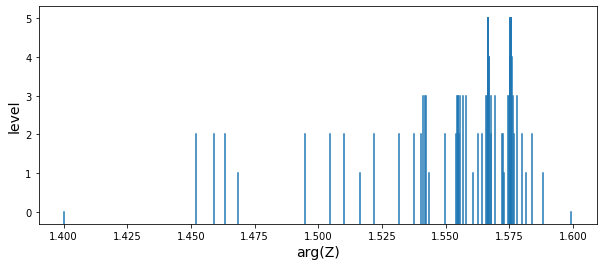

In [40]:
yoffset = 0.3
xoffset = 0.01
plt.clf
plotx = [arg(gamma.Z) for gamma in plotspectrum]
ploty = [gamma.lvl for gamma in plotspectrum]
plt.figure(figsize=(10,4))
plt.axis([plotx[0]-xoffset, plotx[-1]+xoffset, -yoffset, maxlvl+yoffset])
for i in range(len(plotx)):
    plt.axvline(x=plotx[i], ymin=-yoffset, ymax=(ploty[i]+yoffset)/(maxlvl+2*yoffset))
plt.xlabel("arg(Z)",size=14)
plt.ylabel("level",size=14)
plt.show()

We also colorise charges for nicer visualization

In [41]:
#Colorise states simply by level
colorpalette = ["tab:red", "tab:blue", "tab:green",
                "tab:orange", "tab:cyan", "tab:purple", "tab:olive", "tab:brown"
               ]
colors = [colorpalette[gamma.lvl] for gamma in plotspectrum]

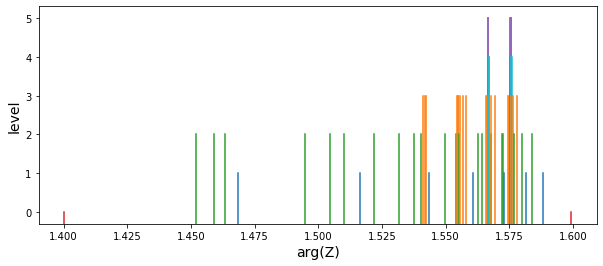

In [42]:
yoffset = 0.3
xoffset = 0.01
plt.clf
plotx = [arg(gamma.Z) for gamma in plotspectrum]
ploty = [gamma.lvl for gamma in plotspectrum]
plt.figure(figsize=(10,4))
plt.axis([plotx[0]-xoffset, plotx[-1]+xoffset, -yoffset, maxlvl+yoffset])
for i in range(len(plotx)):
    plt.axvline(x=plotx[i], ymin=-yoffset, ymax=(ploty[i]+yoffset)/(maxlvl+2*yoffset), c=colors[i])
plt.xlabel("arg(Z)",size=14)
plt.ylabel("level",size=14)
plt.savefig('figurename.png')
plt.show()